## TODO
Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. 

Применить модели на тестовую выборку и оценить корреляцию.

Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

Выполнить задание 2 для трех моделей.

(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

(опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [80]:
import time
import pickle
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import gmean, rankdata
import seaborn as sns
from matplotlib import pyplot as plt
from copy import deepcopy


import warnings
warnings.filterwarnings("ignore")

Использован baseline с кодировкой категориальных признаков

In [2]:
def encode_labels(data: pd.DataFrame) -> pd.DataFrame:
    
    """
    Применяет Label Encoder к каждому категориальному признаку.
    
    Input:
    ------
    data: pd.DataFrame
        Исходный датасет
    """
    cat_cols = data.select_dtypes(include="object")
    for col in cat_cols:
        data[col] = LabelEncoder().fit_transform(data[col].fillna('null'))
        
    return "Done"


In [3]:
with open('data/baseline_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
# Закодируем категориальные признаки для унификации модели
encode_labels(data)

# Выделяем 
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

In [4]:
train.head(3)

,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,...,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,0,1,1.0,157500.0,855000.0,25128.0,4,1,0.019101,15728.0,...,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111
1,0,3,NaN,NaN,NaN,NaN,5,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0.0,135000.0,1006920.0,42660.0,1,1,0.026392,21557.0,...,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803


In [14]:
# class CrossValidation():
#     def __init__(self, params, X, y, cv):
#         self.params = params
#         self.X = X
#         self.y = y
#         self.cv = cv
        

### Используемые функции

In [125]:
def cross_validation(model, X, y, cv, eval_mode='train'):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    
    assert eval_mode in ['train', 'valid'], 'eval mode must be "train" or "valid"'
    
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, eval_mode: {eval_mode}, {X.shape[0]} rows, {X.shape[1]} cols")
#     X[categorical] = X[categorical].astype(str)
    X = X.fillna(-1)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        """FIXME - дополнительные обработчики под модели и режимы обучения"""
        
        if "ExtraTreesClassifier" in str(model) or "LogisticRegression" in str(model):  
            model.fit(
                X=x_train, y=y_train)
        else:   
            model.fit(
                X=x_train, y=y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=0)
    
        if eval_mode=='train':
            oof_preds[train_idx] = model.predict_proba(x_train)[:, 1]
            score = roc_auc_score(y_train, oof_preds[train_idx])
            print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
            folds_scores.append(round(score, 5))
            estimators.append(model)
            
        else:
            oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
            score = roc_auc_score(y_valid, oof_preds[valid_idx])
            print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
            folds_scores.append(round(score, 5))
            estimators.append(model)
            
        """FIXME end"""

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

### Получение OOF прогнозов

In [111]:
xgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "eval_metric": "auc",
    "max_bin": 20,
    "max_depth": 6,
}

cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

lgbm_params = {
    
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "objective": "binary",
    "boosting_type": "gbdt",
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "num_leaves": 25,
    "l2_leaf_reg": 10,
    "early_stopping_round": 50,
    "thread_count": 6,
    "random_seed": 42
}

cv = KFold(n_splits=5, random_state=7777, shuffle=True)

xgb = XGBClassifier(**xgb_params)
catb = CatBoostClassifier(**cb_params)
lgbm = LGBMClassifier(**lgbm_params)

In [50]:
# Модели, OOF для LGBM и XGB моделей (train, valid)

# LGBM
train_lgbm_estimators, train_lgbm_oof_preds = cross_validation(model=lgbm,
                                                 X=train,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='train')

valid_lgbm_estimators, valid_lgbm_oof_preds = cross_validation(model=lgbm,
                                                 X=train,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='valid')

# XGB
train_xgb_estimator, train_xgb_oof_preds = cross_validation(model=xgb,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='train')



valid_xgb_estimator, valid_xgb_oof_preds = cross_validation(model=xgb,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='valid')

# CAT BOOST
train_catb_estimator, train_catb_oof_preds = cross_validation(model=catb,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='train')

valid_catb_estimators, valid_catb_oof_preds = cross_validation(model=catb,
                                                 X=train,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='valid')

Mon Sep 28 16:25:31 2020, Cross-Validation, eval_mode: train, 110093 rows, 52 cols
Fold 1, Valid score = 0.76042
Fold 2, Valid score = 0.75591
Fold 3, Valid score = 0.77303
Fold 4, Valid score = 0.79021
Fold 5, Valid score = 0.77197
Score by each fold: [0.76042, 0.75591, 0.77303, 0.79021, 0.77197]
Mon Sep 28 16:26:12 2020, Cross-Validation, eval_mode: valid, 110093 rows, 52 cols
Fold 1, Valid score = 0.71444
Fold 2, Valid score = 0.71613
Fold 3, Valid score = 0.72437
Fold 4, Valid score = 0.73367
Fold 5, Valid score = 0.72182
Score by each fold: [0.71444, 0.71613, 0.72437, 0.73367, 0.72182]
Mon Sep 28 16:26:55 2020, Cross-Validation, eval_mode: train, 110093 rows, 52 cols
Fold 1, Valid score = 0.8681
Fold 2, Valid score = 0.86852
Fold 3, Valid score = 0.86833
Fold 4, Valid score = 0.86046
Fold 5, Valid score = 0.86952
Score by each fold: [0.8681, 0.86852, 0.86833, 0.86046, 0.86952]
Mon Sep 28 16:52:43 2020, Cross-Validation, eval_mode: valid, 110093 rows, 52 cols
Fold 1, Valid score = 

### Оценка качества базовых моделей

In [51]:
for model_name, oof_preds in [('lightgbm', valid_lgbm_oof_preds),
                              ('xgboost', valid_xgb_oof_preds),
                              ('catboost', valid_catb_oof_preds)]:

    oof_score = roc_auc_score(
        target, oof_preds
    )
    print(f"{model_name} OOF-score = {round(oof_score, 5)}")

lightgbm OOF-score = 0.72148
xgboost OOF-score = 0.72599
catboost OOF-score = 0.72402


### Сбор OOF статистик

In [52]:
# Сбор OOF предсказаний в ДатаФрейм

train_oof_preds = pd.DataFrame(np.vstack((train_lgbm_oof_preds,
                                          train_xgb_oof_preds,
                                          train_catb_oof_preds
                                         )).T,
                               columns=['tLGBM_OOF', 'tXGB_OOF', 'tCATB_OOF'])

valid_oof_preds = pd.DataFrame(np.vstack((valid_lgbm_oof_preds,
                                          valid_xgb_oof_preds,
                                          valid_catb_oof_preds
                                         )).T,
                               columns=['vLGBM_OOF', 'vXGB_OOF', 'vCATB_OOF'])

oof_df = pd.concat([train_oof_preds, valid_oof_preds], axis=1)
oof_df.head(2)

,tLGBM_OOF,tXGB_OOF,tCATB_OOF,vLGBM_OOF,vXGB_OOF,vCATB_OOF
0,0.015432,0.010400,0.019860,0.019684,0.016039,0.022148
1,0.085126,0.085282,0.084786,0.082184,0.082515,0.082016


### Обзор статистик (среднее арифмитическое, геометрическое, усредненные ранги) для каждой модели

In [54]:
oof_df['Stats_group'] = 0  # метка огрегирования кастомных статистик

def avg_rank(x):
    """Усреднение ранга по признаку"""
    
    return np.mean(rankdata(x))

f = {f: [np.mean, gmean, avg_rank] for f in oof_df.columns[:-1]}  # генерация статистик для каждого признака
oof_df.groupby('Stats_group').agg(f).iloc[:,:]

tLGBM_OOF                     tXGB_OOF                     \
                 mean     gmean avg_rank      mean     gmean avg_rank   
Stats_group                                                             
0            0.080849  0.059756  55047.0  0.080783  0.053448  55047.0   

            tCATB_OOF                    vLGBM_OOF                     \
                 mean     gmean avg_rank      mean     gmean avg_rank   
Stats_group                                                             
0            0.080584  0.060977  55047.0  0.080719  0.060318  55047.0   

             vXGB_OOF                    vCATB_OOF                    
                 mean     gmean avg_rank      mean    gmean avg_rank  
Stats_group                                                           
0            0.079074  0.053531  55047.0  0.080487  0.06123  55047.0

### Усрденение и оценка статистик по базовым моделям

In [55]:
# Расчет средней вероятности предсказания модели

mean_preds_2_base_model = np.mean(np.vstack((valid_xgb_oof_preds,
                                             valid_lgbm_oof_preds)).T,axis=1)

gmean_preds_2_base_model = gmean(np.vstack((valid_xgb_oof_preds,
                                            valid_lgbm_oof_preds)).T,axis=1)

rank_preds_2_base_model = np.mean(np.vstack((rankdata(valid_xgb_oof_preds),
                                             rankdata(valid_lgbm_oof_preds))).T,axis=1)

mean_preds_3_base_model = np.mean(np.vstack((valid_xgb_oof_preds,
                                             valid_lgbm_oof_preds,
                                             valid_catb_oof_preds)).T,axis=1)

gmean_preds_3_base_model = gmean(np.vstack((valid_xgb_oof_preds,
                                            valid_lgbm_oof_preds,
                                            valid_catb_oof_preds)).T,axis=1)

rank_preds_3_base_model = np.mean(np.vstack((rankdata(valid_xgb_oof_preds),
                                             rankdata(valid_lgbm_oof_preds),
                                             rankdata(valid_catb_oof_preds))).T,axis=1)


for eval_name, oof_preds in [('mean OOF for (xgb, lgbm) models', mean_preds_2_base_model),
                             ('gmean OOF for (xgb, lgbm) models', gmean_preds_2_base_model),
                             ('mean rank OOF for (xgb, lgbm) models', rank_preds_2_base_model),
                             ('mean OOF for (xgb, lgbm, catb) models', mean_preds_3_base_model),
                             ('gmean OOF for (xgb, lgbm, catb) models', gmean_preds_3_base_model),
                             ('mean rank OOF for (xgb, lgbm, catb) models', rank_preds_3_base_model)]:

    train_oof_score = roc_auc_score(
        target, oof_preds
    )
    print(f"{eval_name}  = {round(train_oof_score, 5)}")

mean OOF for (xgb, lgbm) models  = 0.72681
gmean OOF for (xgb, lgbm) models  = 0.72647
mean rank OOF for (xgb, lgbm) models  = 0.72599
mean OOF for (xgb, lgbm, catb) models  = 0.7273
gmean OOF for (xgb, lgbm, catb) models  = 0.72712
mean rank OOF for (xgb, lgbm, catb) models  = 0.72667


### Оценка корреляции базовых моделей

Высокая корреляция между OOF прогнозами выбранных моделей говорит об их схожей прогнозной силе. При данных параметрах, лучше всего работают все 3 протестированные модели в связке: xgboost + lightgbm + catboost (corr ~0.95). Качество работы усредненных моделей зависит от параметров каждой модели (при общем снижении параметра n_estimators лучше всего показала себя модель lgbm, которая имела высокую корреляцию с xgb, при этом catb показал снижение качества(corr 0.89), что повлияло на качество усреднения 3-х моделей)

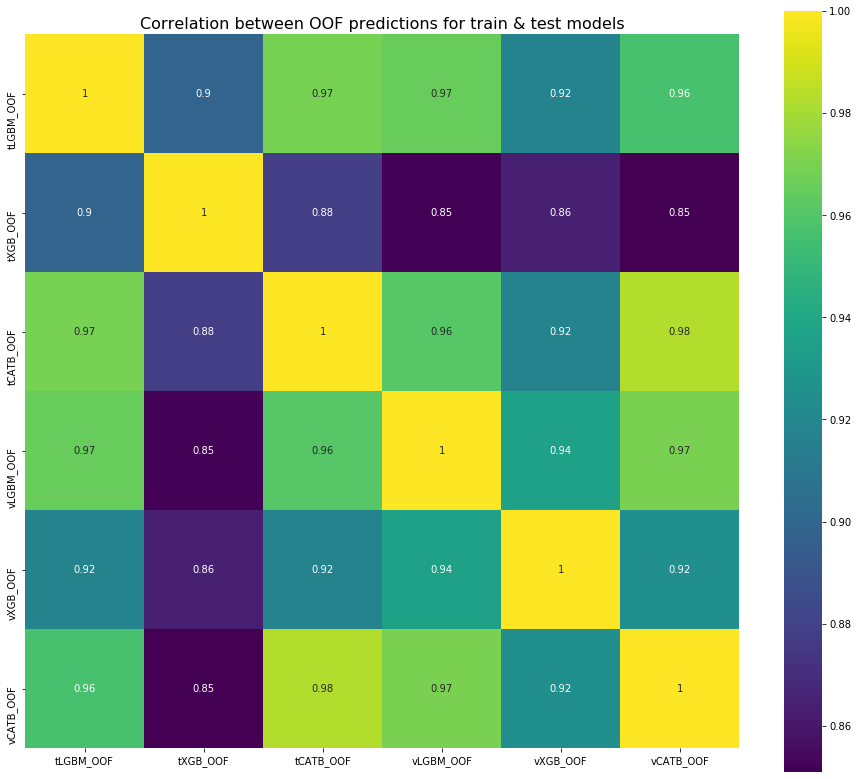

In [56]:

correlation = oof_df.drop("Stats_group",axis=1).corr()

fig, axes = plt.subplots(figsize = (16,14))
plt.title("Correlation between OOF predictions for train & test models", y=1, size=16)
sns.heatmap(correlation, square=True, cmap="viridis", annot=True);

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
train_scores, valid_scores = [], []

params_grid = {
    "penalty": ["l1", "l2"],
    "C": [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
}

for penalty in params_grid["penalty"]:
    scores_penalty_train, scores_penalty_valid = [], []
    pipeline.named_steps["estimator"].penalty = penalty
    for c in params_grid["C"]:
        pipeline.named_steps["estimator"].C = c
        pipeline.fit(x_train, y_train)

        train_pred = pipeline.predict_proba(x_train)[:, 1]
        valid_pred = pipeline.predict_proba(x_valid)[:, 1]

        scores_penalty_train.append(
            roc_auc_score(y_train, train_pred)
        )
        scores_penalty_valid.append(
            roc_auc_score(y_valid, valid_pred)
        )

    train_scores.append(scores_penalty_train)
    valid_scores.append(scores_penalty_valid)

#  Дообучение готовых предсказаний на новой модели

Используем OOF прогнозы для 3-х моделей (полученные на этапе сбора OOF статистик) и дообучим на них модель логистической регрессии с подбором параметров

In [78]:
# lightgbm + xgboost + catboost --> LogisticRegression 

In [137]:
valid_oof_preds.head(2)

,vLGBM_OOF,vXGB_OOF,vCATB_OOF
0,0.019684,0.016039,0.022148
1,0.082184,0.082515,0.082016


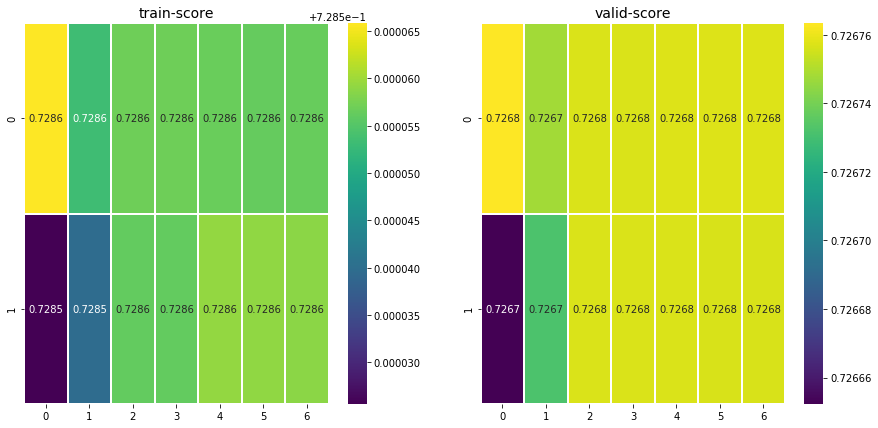

In [92]:
X_train_meta, X_valid_meta, y_train_meta, y_valid_meta = train_test_split(valid_oof_preds, target, stratify=target)

pipeline = Pipeline(
    steps=[
        ("scaling", RobustScaler()),
        ("estimator", LogisticRegression(random_state=42, solver="liblinear"))
    ]
)


train_scores, valid_scores = [], []

params_grid = {
    "penalty": ["l1", "l2"],
    "C": [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
}

for penalty in params_grid["penalty"]:
    scores_penalty_train, scores_penalty_valid = [], []
    pipeline.named_steps["estimator"].penalty = penalty
    for c in params_grid["C"]:
        pipeline.named_steps["estimator"].C = c
        pipeline.fit(X_train_meta, y_train_meta)

        train_pred = pipeline.predict_proba(X_train_meta)[:, 1]
        valid_pred = pipeline.predict_proba(X_valid_meta)[:, 1]

        scores_penalty_train.append(
            roc_auc_score(y_train_meta, train_pred)
        )
        scores_penalty_valid.append(
            roc_auc_score(y_valid_meta, valid_pred)
        )

    train_scores.append(scores_penalty_train)
    valid_scores.append(scores_penalty_valid)
    
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].set_ylabel("penalty", fontsize=14)
axes[0].set_title("train-score", fontsize=14)
sns.heatmap(train_scores, annot=True, linewidths=1, fmt=".4g", cmap="viridis", ax=axes[0])

axes[1].set_ylabel("penalty", fontsize=14)
axes[1].set_title("valid-score", fontsize=14)
sns.heatmap(valid_scores, annot=True, linewidths=1, fmt=".4g", cmap="viridis", ax=axes[1])
plt.show()

In [155]:
lr_clf = LogisticRegression(random_state=42, solver="liblinear", C=10e-1)

meta_lr_estimators, meta_lr_oof_preds = cross_validation(model=lr_clf,
                                                 X=valid_oof_preds,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='valid')

oof_score = roc_auc_score(target, meta_lr_oof_preds)
print(f"\nLogisticRegression as meta-model OOF-score = {round(oof_score, 5)}")

Mon Sep 28 19:40:25 2020, Cross-Validation, eval_mode: valid, 110093 rows, 3 cols
Fold 1, Valid score = 0.72162
Fold 2, Valid score = 0.72424
Fold 3, Valid score = 0.73132
Fold 4, Valid score = 0.73998
Fold 5, Valid score = 0.72588
Score by each fold: [0.72162, 0.72424, 0.73132, 0.73998, 0.72588]

LogisticRegression as meta-model OOF-score = 0.72767


Получили прирост качества порядка сотых долей п.п.

Попробуем заменить мета-классификатор, для этого скормим пресдсказания одной из базовой модели

In [154]:
meta_clf = LGBMClassifier(**lgbm_params)

meta_lgbm_estimators, meta_lgbm_oof_preds = cross_validation(model=meta_clf,
                                                 X=valid_oof_preds,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='valid')

oof_score = roc_auc_score(target, meta_lgbm_oof_preds)
print(f"\nLightgbm as meta-model OOF-score = {round(oof_score, 5)}")

Mon Sep 28 19:38:23 2020, Cross-Validation, eval_mode: valid, 110093 rows, 3 cols
Fold 1, Valid score = 0.72152
Fold 2, Valid score = 0.72335
Fold 3, Valid score = 0.72801
Fold 4, Valid score = 0.73611
Fold 5, Valid score = 0.72117
Score by each fold: [0.72152, 0.72335, 0.72801, 0.73611, 0.72117]

Lightgbm as meta-model OOF-score = 0.7249


Lightgbm в качестве мета-классификатора не показал прироста качества

In [156]:
# ТЕСТ LR в качестве самостоятельного классификатора
valid_lr_estimators, valid_lr_oof_preds = cross_validation(model=lr_clf,
                                                 X=train,
                                                 y=target,
                                                 cv=cv,
                                                 eval_mode='valid')

oof_score = roc_auc_score(target, valid_lr_oof_preds)
print(f"LR OOF-score = {round(oof_score, 5)}")

Mon Sep 28 19:43:25 2020, Cross-Validation, eval_mode: valid, 110093 rows, 52 cols
Fold 1, Valid score = 0.62403
Fold 2, Valid score = 0.61343
Fold 3, Valid score = 0.62808
Fold 4, Valid score = 0.61693
Fold 5, Valid score = 0.61795
Score by each fold: [0.62403, 0.61343, 0.62808, 0.61693, 0.61795]
LR OOF-score = 0.61952


# Stacking

Для оценки используем  готовый модуль `mlxtend`.

In [158]:
from mlxtend.classifier import StackingCVClassifier

In [159]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.3, stratify=target)

In [160]:
# Убираем early_stopping rounds
catb_n_esr_params = deepcopy(cb_params)
catb_n_esr_params.pop('early_stopping_round', None)

# META - LIGHTGBM
lgbm_no_esr_params = deepcopy(lgbm_params)
lgbm_no_esr_params.pop('early_stopping_round', None)

xxgb = XGBClassifier(**xgb_params)
xcatb = CatBoostClassifier(**catb_n_esr_params)
xlgbm = LGBMClassifier(**lgbm_no_esr_params)

In [161]:
stack = StackingCVClassifier(classifiers=(xxgb, xlgbm, xcatb),
                            meta_classifier=xcatb, cv=5,
                            use_probas=True,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42,
                            n_jobs=6)

stack.fit(X_train, y_train)

0:	total: 55.8ms	remaining: 1m 51s
10:	total: 582ms	remaining: 1m 45s
20:	total: 1.1s	remaining: 1m 43s
30:	total: 1.62s	remaining: 1m 42s
40:	total: 2.13s	remaining: 1m 41s
50:	total: 2.66s	remaining: 1m 41s
60:	total: 3.15s	remaining: 1m 40s
70:	total: 3.67s	remaining: 1m 39s
80:	total: 4.18s	remaining: 1m 39s
90:	total: 4.72s	remaining: 1m 39s
100:	total: 5.25s	remaining: 1m 38s
110:	total: 5.77s	remaining: 1m 38s
120:	total: 6.27s	remaining: 1m 37s
130:	total: 6.8s	remaining: 1m 37s
140:	total: 7.32s	remaining: 1m 36s
150:	total: 7.85s	remaining: 1m 36s
160:	total: 8.39s	remaining: 1m 35s
170:	total: 8.92s	remaining: 1m 35s
180:	total: 9.47s	remaining: 1m 35s
190:	total: 10s	remaining: 1m 34s
200:	total: 10.6s	remaining: 1m 34s
210:	total: 11.1s	remaining: 1m 34s
220:	total: 11.6s	remaining: 1m 33s
230:	total: 12.2s	remaining: 1m 33s
240:	total: 12.7s	remaining: 1m 32s
250:	total: 13.3s	remaining: 1m 32s
260:	total: 13.8s	remaining: 1m 32s
270:	total: 14.4s	remaining: 1m 31s
280:	t

300:	total: 11.6s	remaining: 1m 5s
310:	total: 12s	remaining: 1m 5s
320:	total: 12.4s	remaining: 1m 4s
330:	total: 12.8s	remaining: 1m 4s
340:	total: 13.2s	remaining: 1m 4s
350:	total: 13.6s	remaining: 1m 3s
360:	total: 14s	remaining: 1m 3s
370:	total: 14.4s	remaining: 1m 3s
380:	total: 14.8s	remaining: 1m 2s
390:	total: 15.2s	remaining: 1m 2s
400:	total: 15.5s	remaining: 1m 2s
410:	total: 15.9s	remaining: 1m 1s
420:	total: 16.3s	remaining: 1m 1s
430:	total: 16.7s	remaining: 1m
440:	total: 17.1s	remaining: 1m
450:	total: 17.5s	remaining: 1m
460:	total: 17.9s	remaining: 59.9s
470:	total: 18.3s	remaining: 59.5s
480:	total: 18.7s	remaining: 59.1s
490:	total: 19.1s	remaining: 58.7s
500:	total: 19.5s	remaining: 58.4s
510:	total: 19.9s	remaining: 58s
520:	total: 20.3s	remaining: 57.6s
530:	total: 20.7s	remaining: 57.3s
540:	total: 21.1s	remaining: 56.9s
550:	total: 21.5s	remaining: 56.5s
560:	total: 21.9s	remaining: 56.1s
570:	total: 22.3s	remaining: 55.8s
580:	total: 22.7s	remaining: 55.5s


StackingCVClassifier(classifiers=(XGBClassifier(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                eval_metric='auc', gamma=None,
                                                gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=0.01, max_bin=20,
                                                max_delta_step=None,
                                                max_depth=6,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constrai...
      

In [162]:
stack_pred = stack.predict_proba(X_valid)
score = roc_auc_score(y_valid, stack_pred[:, 1])
score

0.7277379493114808

Стекинг из пакета показал лучший результат

# Random Forest

In [164]:
rf_params = {
    "n_estimators": 500,
    "max_features": 'auto',
    "min_samples_leaf": 1,
    "max_depth": 8,
    "verbose": 0,
    "random_state": 42,
    "n_jobs": 6,
}

# TODO: Настроить параметры RF
rf = ExtraTreesClassifier(**rf_params)

# RF
train_rf_estimator, train_rf_oof_preds = cross_validation(model=rf,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='train')



valid_rf_estimator, valid_rf_oof_preds = cross_validation(model=rf,
                                               X=train,
                                               y=target,
                                               cv=cv,
                                               eval_mode='valid')

Mon Sep 28 21:04:39 2020, Cross-Validation, eval_mode: train, 110093 rows, 52 cols
Fold 1, Valid score = 0.73573
Fold 2, Valid score = 0.73564
Fold 3, Valid score = 0.73317
Fold 4, Valid score = 0.73294
Fold 5, Valid score = 0.73531
Score by each fold: [0.73573, 0.73564, 0.73317, 0.73294, 0.73531]
Mon Sep 28 21:05:54 2020, Cross-Validation, eval_mode: valid, 110093 rows, 52 cols
Fold 1, Valid score = 0.69962
Fold 2, Valid score = 0.70388
Fold 3, Valid score = 0.71602
Fold 4, Valid score = 0.71517
Fold 5, Valid score = 0.71216
Score by each fold: [0.69962, 0.70388, 0.71602, 0.71517, 0.71216]


In [165]:
oof_score = roc_auc_score(target, valid_rf_oof_preds)
print(f"ExtraTreesClassifier OOF-score = {round(oof_score, 5)}")

ExtraTreesClassifier OOF-score = 0.70852


In [166]:
oof_df_plus_rf = oof_df.copy()
oof_df_plus_rf['tRF_OOF'] = train_rf_oof_preds
oof_df_plus_rf['vRF_OOF'] = valid_rf_oof_preds

In [167]:
oof_df_plus_rf

,tLGBM_OOF,tXGB_OOF,tCATB_OOF,vLGBM_OOF,vXGB_OOF,vCATB_OOF,Stats_group,tRF_OOF,vRF_OOF
0,0.015432,0.010400,0.019860,0.019684,0.016039,0.022148,0,0.027697,0.028837
1,0.085126,0.085282,0.084786,0.082184,0.082515,0.082016,0,0.085153,0.082489
2,0.056289,0.058343,0.057262,0.072842,0.112018,0.057986,0,0.068524,0.072572
3,0.219608,0.243013,0.202971,0.222852,0.199096,0.235015,0,0.185096,0.187438
4,0.085126,0.085282,0.084786,0.084084,0.084623,0.083990,0,0.085153,0.084408
...,...,...,...,...,...,...,...,...,...
110088,0.085126,0.085282,0.084786,0.085526,0.085591,0.085092,0,0.085153,0.085665
110089,0.059597,0.053670,0.053184,0.050172,0.047654,0.053255,0,0.063111,0.064190
110090,0.085126,0.085282,0.084786,0.082184,0.082515,0.082016,0,0.085153,0.082489
110091,0.024033,0.025221,0.029086,0.052160,0.039743,0.030030,0,0.033636,0.032685


In [168]:
oof_df_plus_rf['Stats_group'] = 0  # метка огрегирования кастомных статистик

def avg_rank(x):
    """Усреднение ранга по признаку"""
    return np.mean(rankdata(x))

f = {f: [np.mean, gmean, avg_rank] for f in oof_df_plus_rf[["tRF_OOF", "vRF_OOF"]]}  # генерация статистик для каждого признака
oof_df_plus_rf.groupby('Stats_group').agg(f)

tRF_OOF                      vRF_OOF                   
                 mean     gmean avg_rank      mean     gmean avg_rank
Stats_group                                                          
0            0.080902  0.072109  55047.0  0.080842  0.072038  55047.0

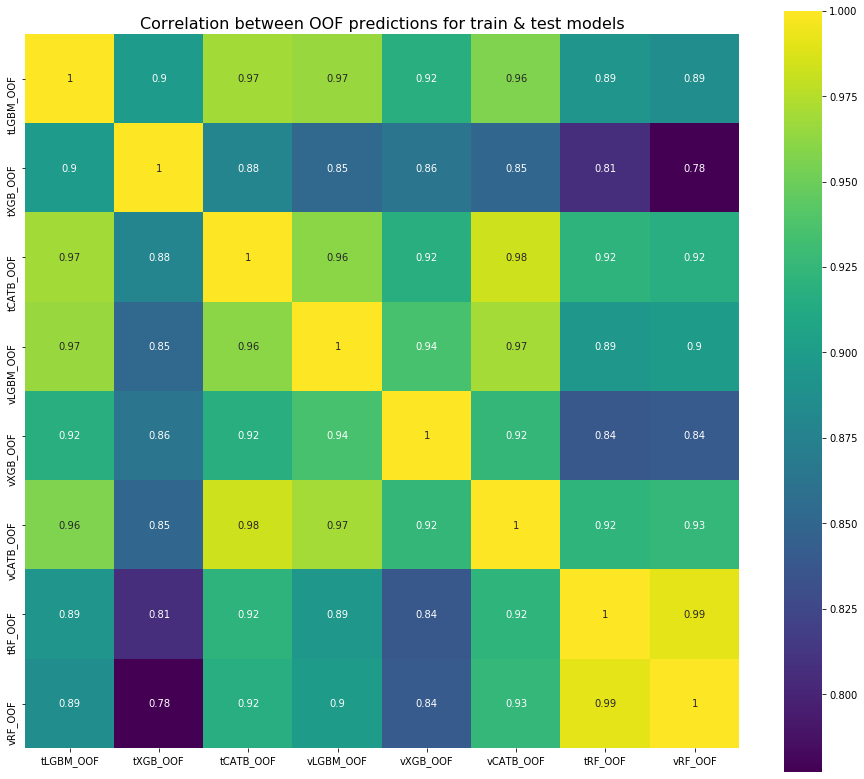

In [169]:
correlation = oof_df_plus_rf.drop("Stats_group",axis=1).corr()

fig, axes = plt.subplots(figsize = (16,14))
plt.title("Correlation between OOF predictions for train & test models", y=1, size=16)
sns.heatmap(correlation, square=True, cmap="viridis", annot=True);